# Face detection

Here, we are going to develop the solution for face detection

## 1. Data
### 1.1 Load

In [26]:
import glob
from skimage.io import imread
import numpy as np

faces_path = "../data/face_detection/cropped_faces/*.pgm"
non_faces_path = "../data/face_detection/non_faces_images/neg_cropped_img/*.png"


def load_classes_paths(faces_path, non_faces_path):
    face_paths = glob.glob(faces_path)
    non_face_paths = glob.glob(non_faces_path)
    
    return face_paths, non_face_paths

face_paths, non_face_paths = load_classes_paths(faces_path, non_faces_path)

print("Number of faces in the dataset: {:d}".format(len(face_paths)))
print("Number of non-faces in the dataset: {:d}".format(len(non_face_paths)))

def load_data_from_paths(face_paths, non_face_paths):
    feats_data, labels_data = [], []
    for path in face_paths:
        feats_data.append(imread(path, as_grey=True))
        labels_data.append(1) # for faces
            
    for path in non_face_paths:
        feats_data.append(imread(path, as_grey=True))
        labels_data.append(0) # for non faces

    X = np.array(feats_data)
    y = np.array(labels_data)
    
    return X, y

X_all, y_all = load_data_from_paths(face_paths, non_face_paths)

assert len(X_all) == len(y_all)

print("Number of elements: {:d}".format(len(X_all)))

Number of faces in the dataset: 7308
Number of non-faces in the dataset: 4902
Number of elements: 12210


#### 1.1.1 Visualize

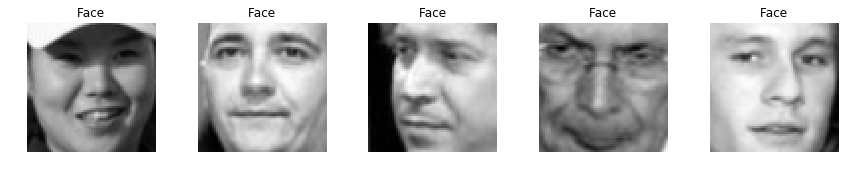

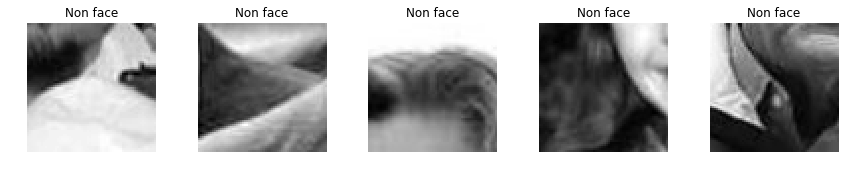

In [27]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from random import randrange

def get_random_images(n = 1):
    faces = []
    non_faces = []
    
    while len(faces) < n:
        index = randrange(len(X_all))
        y = y_all[index]
        
        if y == 1:
            faces.append(X_all[index])
    
    while len(non_faces) < n:
        index = randrange(len(X_all))
        y = y_all[index]
        
        if y == 0:
            non_faces.append(X_all[index])
        
    return faces, non_faces

def plot_images(images, title):
    f, ax = plt.subplots(1, len(images), figsize=(12, 12))
    f.tight_layout()
    
    for i, image in enumerate(images):
        ax[i].axis("off")
        ax[i].imshow(image, cmap="gray")
        ax[i].set_title(title)

face_imgs, non_face_imgs = get_random_images(5)

plot_images(face_imgs, "Face")
plot_images(non_face_imgs, "Non face")

### 1.2 Extract features

In [49]:
from skimage.feature import hog

# from https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/2b62a1c3-e151-4a0e-b6b6-e424fa46ceab/lessons/fd66c083-4ccb-4fe3-bda1-c29db76f50a0/concepts/d479f43a-7bbb-4de7-9452-f6b991ece599
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features

def extract_features(image):
   
    # Define HOG parameters
    orient = 9
    pix_per_cell = 8    
    cell_per_block = 2
    
    hog_feats = get_hog_features(
            image, 
            orient, 
            pix_per_cell, 
            cell_per_block, 
            vis=False, 
            feature_vec=True
        )

    return hog_feats

#### 1.2.1 Visualize

/mnt/linux_shared/shared/anaconda3/envs/icv/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


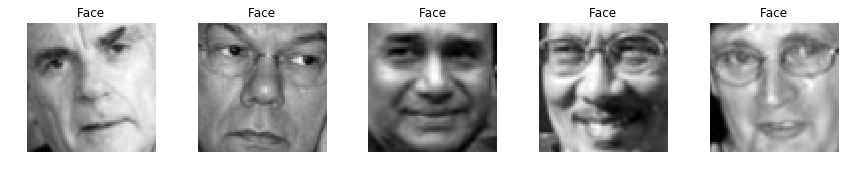

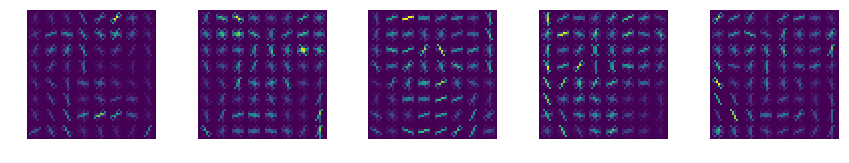

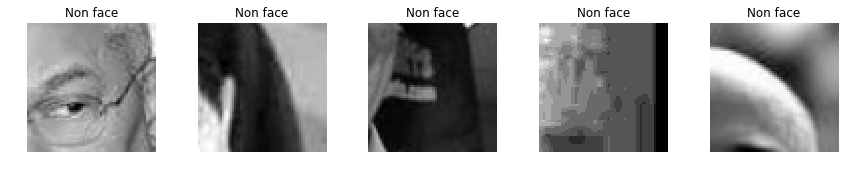

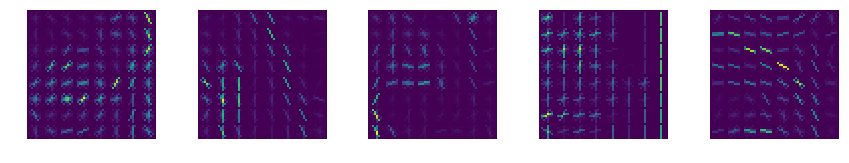

In [50]:
def plot_hog(images, title):
    
    # Define HOG parameters
    orient = 9
    pix_per_cell = 8
    cell_per_block = 2
    
    f, ax = plt.subplots(1, len(images), figsize=(12, 12))
    f.tight_layout()
    
    for i, image in enumerate(images):
        features, hog_image = get_hog_features(
            image, 
            orient, 
            pix_per_cell, 
            cell_per_block, 
            vis=True, 
            feature_vec=False
        )
        
        ax[i].axis("off")
        ax[i].imshow(hog_image)
        ax[i].set_title(title)

face_imgs, non_face_imgs = get_random_images(5)

plot_images(face_imgs, "Face")
plot_hog(face_imgs, "")

plot_images(non_face_imgs, "Non face")
plot_hog(non_face_imgs, "")

In [51]:
from sklearn.model_selection import train_test_split

X_feats_all = []
for el in X_all:
    X_feats_all.append(extract_features(el))

X_feats_all = np.array(X_feats_all)

X_train, X_test, y_train, y_test = train_test_split(X_feats_all, y_all, test_size=0.3, random_state=50)

/mnt/linux_shared/shared/anaconda3/envs/icv/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


In [52]:
print("Number of features per image: {:d}".format(X_train.shape[1]))

Number of features per image: 1764


## 2. Classifier

/mnt/linux_shared/shared/anaconda3/envs/icv/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(500, kernel_regularizer=<keras.reg..., kernel_initializer="uniform")`
/mnt/linux_shared/shared/anaconda3/envs/icv/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(100, kernel_initializer="uniform")`
/mnt/linux_shared/shared/anaconda3/envs/icv/lib/python3.6/site-packages/ipykernel_launcher.py:34: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, kernel_initializer="uniform")`
/mnt/linux_shared/shared/anaconda3/envs/icv/lib/python3.6/site-packages/ipykernel_launcher.py:37: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, kernel_initializer="uniform")`
/mnt/linux_shared/shared/anaconda3/envs/icv/lib/python3.6/site-packages/ipykernel_launcher.py:101: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is no

Epoch 1/30
200/200 [==============================] - 7s - loss: 0.8098 - binary_accuracy: 0.9002 - val_loss: 0.2292 - val_binary_accuracy: 0.9440
Epoch 2/30
200/200 [==============================] - 7s - loss: 0.1181 - binary_accuracy: 0.9823 - val_loss: 0.1290 - val_binary_accuracy: 0.96970.982
Epoch 3/30
200/200 [==============================] - 7s - loss: 0.1489 - binary_accuracy: 0.9764 - val_loss: 0.1837 - val_binary_accuracy: 0.9762
Epoch 4/30
200/200 [==============================] - 8s - loss: 0.1155 - binary_accuracy: 0.9835 - val_loss: 0.1554 - val_binary_accuracy: 0.9798
Epoch 5/30
200/200 [==============================] - 7s - loss: 0.1464 - binary_accuracy: 0.9793 - val_loss: 0.1106 - val_binary_accuracy: 0.9828
Epoch 6/30
200/200 [==============================] - 8s - loss: 0.1129 - binary_accuracy: 0.9824 - val_loss: 0.1514 - val_binary_accuracy: 0.9719
Epoch 7/30
200/200 [==============================] - 7s - loss: 0.1039 - binary_accuracy: 0.9844 - val_loss: 0.1

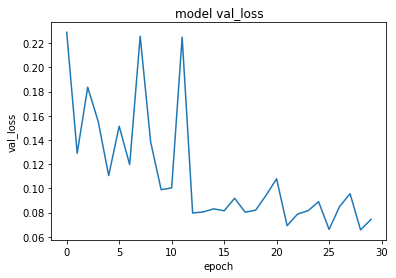

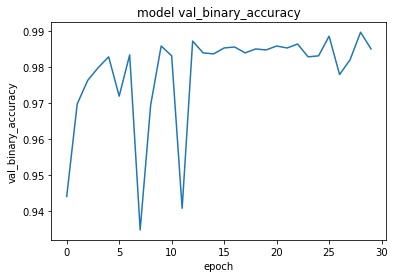

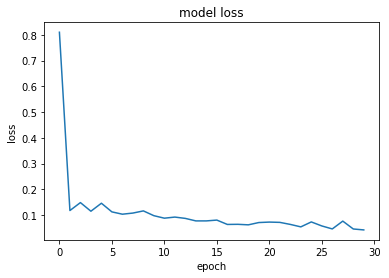

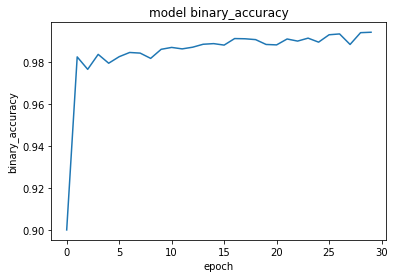

In [58]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, ELU, Activation, Lambda, Dropout
from keras.layers.convolutional import Convolution2D
from keras.optimizers import Adam
from keras import regularizers
    
def get_model(learning, n_feats):
        
    model = Sequential()
    model.add(Activation('relu', batch_input_shape=(None, n_feats)))

#     model.add(Dense(1250))
#     model.add(Activation('relu'))
    
#     model.add(Dense(1000))
#     model.add(Activation('relu'))
    
#     model.add(Dense(750))
#     model.add(Activation('relu'))
    
    model.add(Dense(500, init='uniform',
                    kernel_regularizer=regularizers.l2(0.01)))
    model.add(Activation('relu'))
    
#     model.add(Dense(250))
#     model.add(Activation('relu'))

    model.add(Dense(100, init='uniform'))
    model.add(Activation('relu'))
    
#     model.add(Dense(50))
#     model.add(Activation('relu'))

    model.add(Dense(10, init='uniform'))
    model.add(Activation('relu'))

    model.add(Dense(1, init='uniform'))
    model.add(Activation('sigmoid'))

    optimizer = Adam(lr=learning)
    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=['binary_accuracy'])

    return model

from random import randrange

def generator(X, y, batch_size):

    total_input = len(X)
    
    while True:
        features, targets = [], []
        i = 0
        while len(features) < batch_size:
            index = randrange(0, total_input)
            feats = X[index]
            labels = y[index]
           
            features.append(feats)
            targets.append(labels)
            
        yield (np.array(features), np.array(targets))

def getFeaturesTargets(X, y):
    feats = []
    targets = []
    for feat, label in zip(X, y):
        feats.append(feat)
        targets.append(label)

    return np.array(feats), np.array(targets)

def plot_metrics(history):
    keys = history.history.keys()

    for k in keys:
        plt.clf()
        plt.plot(history.history[k])
        plt.title("model " + k)
        plt.ylabel(k)
        plt.xlabel('epoch')
        plt.show()
        
import json

def train_model(X_train, y_train, X_val, y_val):
    learning_rate = 0.001
    training_size = 200
    batch_size = 50
    epochs = 30
#     epochs = 5

    model = get_model(learning_rate, len(X_train[0]))
#     history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size)
#     print(model.evaluate(X_val, y_val))
#     print(model.metrics_names)
    history =  model.fit_generator(
            generator(X_train, y_train, batch_size),
            samples_per_epoch = training_size,
            validation_data = getFeaturesTargets(X_val, y_val),
            nb_epoch = epochs
        )
 
    plot_metrics(history) 
    
    model.save_weights("model.h5")
    with open("model.json", "w+") as outfile:
        json.dump(model.to_json(), outfile)

train_model(X_train, y_train, X_test, y_test)

## 3. Validation

### 3.1 Sliding Window

In [62]:
from math import floor
def slide_image(image, window_size, stride):
        
    patches = []
    locations = []
    h, w = image.shape
    
    for j in range(0, h - window_size, stride):
        for i in range(0, w - window_size, stride):
            single_patch = image[i:i+window_size, j:j+window_size]
            patches.append(single_patch)
            locations.append([i, j, window_size, window_size])
            
    return patches, locations

#### 3.1.1 Visualization

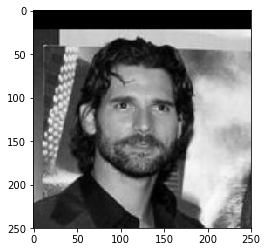

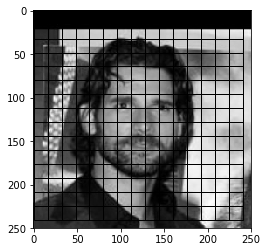

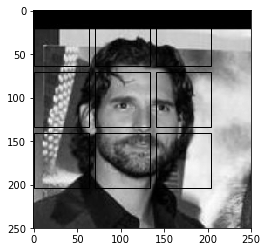

In [179]:
from skimage.draw import polygon_perimeter
import matplotlib.patches as pypatches

def get_random_val_image():
    imgs_path = "../data/face_detection/val_face_detection_images/*.jpg"
    all_paths = glob.glob(imgs_path)
    
    index = randrange(len(all_paths))
    image = imread(all_paths[index], as_grey=True)
    
    return image

def plot_windows(image, window_size=64, stride=16):
   
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.imshow(image, cmap='gray')

    patches, locations = slide_image(image, window_size, stride)
    
    for idx, loc in enumerate(locations):
        ax.add_patch(pypatches.Rectangle(
                (loc[0], loc[1]),
                loc[2],
                loc[3],
                fill = False                
            )
        )

image = get_random_val_image()
plt.imshow(image, cmap='gray')

plot_windows(np.copy(image), stride=16)
plot_windows(np.copy(image), stride=70)    

### 3.2 Predictions

In [83]:
from keras.models import model_from_json

def load_clf():
    with open("model.json", 'r') as jfile:
        model = model_from_json(json.loads(jfile.read()))\

    model.compile("adam", "binary_crossentropy")
    model.load_weights("model.h5")
    
    return model

def predict(clf, patch_image):
    feats = extract_features(patch_image)
    pred = clf.predict(feats.reshape((1, -1)), batch_size=1)
    pred = np.abs(pred[0][0])
    
    return pred

def try_prediction(clf, image):
    patches, locations = slide_image(image, 64, 48)
    
    predictions = []
    
    for patch in patches:
        pred = predict(clf, patch)
        predictions.append(pred)
        
    return locations, predictions

#### 3.2.1 Visualization

/mnt/linux_shared/shared/anaconda3/envs/icv/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


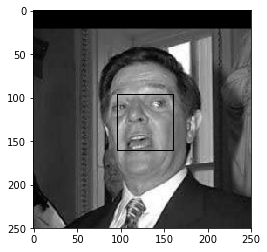

In [202]:
def plot_predictions(clf, image):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.imshow(image, cmap='gray')
    
    locations, predictions = try_prediction(clf, image)
    
    for loc, pred in zip(locations, predictions):
        if pred > 0.9:
            ax.add_patch(pypatches.Rectangle(
                (loc[0], loc[1]),
                loc[2],
                loc[3],
                fill = False                
            )
        )
    
clf = load_clf()
image = get_random_val_image()
plot_predictions(clf, image)

### 3.3 Evaluation set

In [92]:
def evaluate_model(clf, val_log_name):
    
    val_path = "../data/face_detection/val_raw_images/*/*"
    val_paths = glob.glob(val_path)
    
    with open(val_log_name, "w+") as log_file:
        for idx, path in enumerate(val_paths):
            image = imread(path, as_grey=True)
            locations, predictions = try_prediction(clf, image)
            
            for loc, pred in zip(locations, predictions):
                line = "{:d}, {:.6f}, {:d}, {:d}, {:d}, {:d}\n".format(
                idx, pred, loc[0], loc[1], loc[2], loc[3])
                log_file.write(line)
    log_file.close()

clf = load_clf()
evaluate_model(clf, "eval_log.txt")

/mnt/linux_shared/shared/anaconda3/envs/icv/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)
